# tests for a chat bot for a motorcycle store

In [1]:
import os
from typing import Dict, List, Tuple, Any, Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
import google.generativeai as genai
from langchain.schema import HumanMessage, SystemMessage
from langgraph.graph import Graph, StateGraph, START, END
from langgraph.prebuilt import ToolInvocation, ToolExecutor
from langgraph.graph.message import add_messages
from langchain.tools import Tool
from langchain.vectorstores import FAISS
import base64
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
import glob
import seaborn as sns

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.ai import AIMessage

from IPython.display import Image as Display

# Set your Google API key
# os.environ["GOOGLE_API_KEY"] = "your_google_api_key_here"


# build the initial stock data base

## build with multimodal embedding (CILP)
when we will want to search the stock data with both texts and images

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
# print("Output results for model %s" % outputs)
# print(outputs)
# print(outputs.image_embeds)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)

In [ ]:

# outputs.image_embeds.shape
# outputs.image_embeds.norm(dim=-1, keepdim=True)
# # outputs.text_embeds.shape
# outputs.text_embeds.norm(dim=-1, keepdim=True)

# outputs.image_embeds * outputs.text_embeds[0].T
# F.cosine_similarity(outputs.image_embeds,outputs.text_embeds)
# # F.cosine_similarity(outputs.image_embeds,outputs.text_embeds).softmax(dim=1)

In [ ]:

# Initialize the Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
multimodal_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

# Initialize CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # Initialize embeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
# embeddings = model

# Function to get CLIP embeddings
def get_clip_embeddings(image_path, text):
    image = Image.open(image_path)
    # print(type(image))
    inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True).to(device)
    # print(text)
    # print(inputs.keys())
    # print(inputs)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    
    # Normalize embeddings
    image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
    
    return image_embeds[0].cpu().numpy(), text_embeds[0].cpu().numpy()

# Function to process stock folder
def process_stock_folder(stock_folder):
    items = []
    for item_folder in os.listdir(stock_folder):
        item_path = os.path.join(stock_folder, item_folder)
        if os.path.isdir(item_path):
            item_description = item_folder
            image_files = glob.glob(os.path.join(item_path, "*.[jJ][pP][gG]")) + \
                          glob.glob(os.path.join(item_path, "*.[pP][nN][gG]"))
            
            if image_files:
                image_path = image_files[0]  # Use the first image file
                image_embed, text_embed = get_clip_embeddings(image_path, item_description)
                
                items.append({
                    "description": item_description,
                    "image_path": image_path,
                    "image_embedding": image_embed,
                    "text_embedding": text_embed
                })
    
    return pd.DataFrame(items)

# Process the stock folder and create DataFrame
current_dir = os.getcwd()
stock_folder = os.path.join(current_dir, "stock")  # Relative path from current working directory
stock_df = process_stock_folder(stock_folder)

# Display the first few rows of the DataFrame
print(stock_df.head())

# Initialize vector store for product inventory using the text embeddings
# vector_store = FAISS.from_texts(stock_df['description'].tolist(), embeddings)

# Print the contents of the stock folder
print("Contents of the stock folder:")
print(os.listdir(stock_folder))



In [ ]:
stock_df["text_embedding"][0].shape
stock_df


In [ ]:

# # Set up the embeddings in a dataframe.
# df = pd.DataFrame(stock_df.loc[:,['image_embedding','text_embedding']], index=stock_df['description'])
# # Perform the similarity calculation
# sim = df['image_embedding'] @ df['text_embedding'].T
# # Draw!
# sns.heatmap(sim, vmin=0, vmax=1)


In [ ]:

df = pd.DataFrame(index=stock_df['description'].to_list(), columns=stock_df['description'].to_list(),dtype=float)

(stock_df["text_embedding"] @ stock_df["image_embedding"].T).shape
stock_df["text_embedding"][0] @ stock_df["image_embedding"][0]
for i in stock_df.index:
    for j in stock_df.index:
        sim = (stock_df['text_embedding'][i] @ stock_df['image_embedding'][j]).item()
        print(f"Similarity of text {i} with image {j}: {sim}")
        df.iloc[i, j] = float(sim)

df
# sns.heatmap(df, vmin=0, vmax=1)
sns.heatmap(df)


## build with only text embeddings
use provided text embedder

In [2]:

# Initialize the Gemini model
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
# multimodal_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

# # Initialize CLIP model and processor
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # Initialize embeddings
# embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",task_type='semantic_similarity')
document_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",task_type='retrieval_document')
query_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004",task_type='retrieval_query')
# embeddings = model
# genai.embed_content(model='models/text-embedding-004',
#                                content=texts,
#                                task_type='semantic_similarity')


# Function to process stock folder
def process_stock_folder(stock_folder):
    items = []
    for item_folder in os.listdir(stock_folder):
        item_path = os.path.join(stock_folder, item_folder)
        if os.path.isdir(item_path):
            item_description = item_folder
            image_files = glob.glob(os.path.join(item_path, "*.[jJ][pP][gG]")) + \
                          glob.glob(os.path.join(item_path, "*.[pP][nN][gG]"))
            
            if image_files:
                image_path = image_files[0]  # Use the first image file
                # get the embeddedings for the texts
                # print(item_description)
                text_embed = document_embeddings.embed_documents([item_description])
                
                items.append({
                    "description": item_description,
                    "image_path": image_path,
                    # "image_embedding": image_embed,
                    "text_embedding": text_embed
                })
    
    return pd.DataFrame(items)

# Process the stock folder and create DataFrame
current_dir = os.getcwd()
stock_folder = os.path.join(current_dir, "stock")  # Relative path from current working directory
stock_df = process_stock_folder(stock_folder)

# Display the first few rows of the DataFrame
print(stock_df.head())

# Initialize vector store for product inventory using the text embeddings
# vector_store = FAISS.from_texts(stock_df['description'].tolist(), embeddings)
# vector_store = FAISS.from_embeddings(text_embeddings=stock_df["text_embedding"],,metadatas=stock_df.loc[:,["description","image_path"]])

# Print the contents of the stock folder
print("Contents of the stock folder:")
print(os.listdir(stock_folder))


              description                                         image_path  \
0  blue motorcycle helmet  c:\Users\User\Desktop\python-20221118T114714Z-...   
1  blue motorcycle jacket  c:\Users\User\Desktop\python-20221118T114714Z-...   
2  pink motorcycle helmet  c:\Users\User\Desktop\python-20221118T114714Z-...   
3  pink motorcycle jacket  c:\Users\User\Desktop\python-20221118T114714Z-...   

                                      text_embedding  
0  [[-0.005905301310122013, -0.002407571300864219...  
1  [[-0.02997160144150257, -0.011836163699626923,...  
2  [[0.002586913760751486, -0.02924327738583088, ...  
3  [[-0.01957322284579277, -0.030731888487935066,...  
Contents of the stock folder:
['blue motorcycle helmet', 'blue motorcycle jacket', 'pink motorcycle helmet', 'pink motorcycle jacket']


In [3]:
# def search_product(query: str) -> List[Dict[str, Any]]:
#     results = vector_store.similarity_search(query, k=3)
#     return [{"product_info": doc.page_content, "description": doc.metadata["description"]} for doc in results]
def search_product(query: str) -> pd.DataFrame:
    """Get item request description from the buyer and return the two most fitting products from the stock database.
    
    Returns:
        a pandas DataFrame of the two most fitting products.
    """
    test_query_embedding = query_embeddings.embed_query(query)
    scores = stock_df["text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
    return stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path"]]

# test_query_text = "i want a pink helmet"
test_query_text = "find me a jacket"
# test_query_embedding = query_embeddings.embed_query(test_query_text)
search_product(test_query_text)


,description,image_path
3,pink motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...
1,blue motorcycle jacket,c:\Users\User\Desktop\python-20221118T114714Z-...


In [ ]:

# len(test_query_embedding)
# stock_df["text_embedding"]
# # stock_df["text_embedding"] @ test_query_embedding
# # test_query_embedding @ stock_df["text_embedding"][0]
# np.array(test_query_embedding)
# stock_df["text_embedding"].to_numpy()

# # similarity_matrix = stock_df["text_embedding"].to_numpy() @ test_query_embedding
# scores = stock_df["text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
# scores.sort_values(ascending=False)
# stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path"]]
# # np.array(test_query_embedding) @ np.array(stock_df["text_embedding"][3][0])

# # stock_df["text_embedding"][0][0]
# # np.array(stock_df["text_embedding"][0]).shape
# # len(stock_df["text_embedding"][0])

# build a test bot

In [4]:

# Initialize the Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
# multimodal_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


class State(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]
    user_type: Literal["seller", "buyer", "unknown"] = "unknown"

    # The current stock database
    stock_database: pd.DataFrame = stock_df

    # Flag indicating that the order is placed and completed.
    finished: bool

# # Define the state
# class State(BaseModel):
#     """State representing the customer's order conversation or seller item input."""
#     messages: List[str] = Field(default_factory=list)
#     current_operation: str = "idle"
#     stock_database: pd.DataFrame = Field(default_factory=pd.DataFrame)


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
MOTORCYCLESTOREBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a MotorcycleStoreBot, an interactive motorcycle store managing system. "
    "there are two types of humans that can talk to you: "
    "\n\ta seller: sellers can look at the stock database and ask to add or remove items from the database."
    "\t\t if they want to add an item they need to give its description in text and give an image of the item."
    "\t\t if they want to remove an item from the database they need to give its description or its index in the database"
    "\n\tcustomer: customers can ask questions about the stock database and ask for help."
    "\t\t if they want to find an item they need to give a description and you will look in the stock database "
    "for the closest available items, if you find an item that is close to what they want you will offer it to them, "
    "if the closest available items are not similar to what they want you will say that we don't have any items close to what they want"

    
    
    # "A human will talk to you about the "
    # "available products you have and you will answer any questions about menu items (and only about "
    # "menu items - no off-topic discussion, but you can chat about the products and their history). "
    # "The customer will place an order for 1 or more items from the menu, which you will structure "
    # "and send to the ordering system after confirming the order with the human. "
    # "\n\n"
    # "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    # "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    # "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    # "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    # "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    # "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    # "You only have the modifiers listed on the menu. "
    # "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    # "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    # "say goodbye!",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to Lior's Motorcycle Store. Type `q` to quit. How may I help you today?"




In [5]:


# add needed tools for the bot
@tool
def search_product(query: str) -> str:
    """Get item request description from the buyer and return the two most fitting products from the stock database.
    
    Returns:
        a list of the two most fitting products.
    """

# @tool
# def add_product(product_description: str, product_image:PIL.JpegImagePlugin.JpegImageFile) -> None:
#     """Add a new product to the stock database.
    
#     Args:
#         product_description (str): Description of the product.
#         product_image (PIL.JpegImagePlugin.JpegImageFile): Image of the product.

#     Returns:
#         None
#     """
@tool
def add_product(product_description: str, product_image_path:str) -> str:
    """Add a new product to the stock database.
    
    Args:
        product_description (str): Description of the product.
        product_image (str): The path to rhe Image of the product.

    Returns:
        Confirmation message indicating success or failure.
    """
  
@tool
def add_to_order(item: str, item_count: int) -> str:
    """Adds the wanted item to the buyer's order, including amount of wanted items.

    Returns:
      The updated order in progress.
    """

@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""
  
@tool
def clear_order():
    """Removes all items from the user's order."""
    
@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def place_order() -> bool:
    """Sends the order to the stock for fulfillment.

    Returns:
      Confirmation message indicating success or failure.
    """


In [30]:


tools = [search_product, add_product, add_to_order, get_order, clear_order, confirm_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(tools)


def human_node(state: State) -> State:
    """Display the last model message to the user, and receive the user's input."""
    print("in human_node")
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")
    print("User:", user_input)

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def maybe_exit_human_node(state: State) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    print("in maybe_exit_human_node")
    if state.get("finished", False):
        return END
    else:
        return "chatbot"
    
def chatbot_with_tools(state: State) -> State:
    # print("started chatbot")
    print("in chatbot")
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([MOTORCYCLESTOREBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    # print(new_output)
    return defaults | state | {"messages": [new_output]}


def seller_or_buyer(state: State) -> Literal["seller", "buyer"]:
    """Decide whether the user is a seller or a buyer based on their message"""
    print("in seller_or_buyer")
    # if state["user_type"] is not "unknown":
    if state["user_type"] != "unknown":
        return state["user_type"]
    else:
        # If the user's type is not known, let's ask the user.
        state["user_type"] = "seller" if input("Are you a seller or a buyer? (seller/buyer): ").lower() == "seller" else "buyer"
        return state["user_type"]
def seller_or_buyer2(state: State) -> Literal["seller", "buyer","__end__","human"]:
    """Decide whether the user is a seller or a buyer based on their message"""
    print("in seller_or_buyer2")
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]
    # print(msg)

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        print("to END")
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # to seller if it want to use add_product
        if any(
            tool["name"] in ["add_product",] for tool in msg.tool_calls
        ):
            print("to seller node")
            return "seller"
        elif any(
            tool["name"] in ["search_product", "add_to_order", "get_order", "clear_order", "confirm_order", "place_order"] for tool in msg.tool_calls
        ):
            print("to buyer node")
            return "buyer"
    else:
        print("to human node")
        return "human"

    
def seller_node(state: State) -> State:
    """The seller node. This is where the seller can add new items to the stock database"""
    print("in seller_node")
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False
    
    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_product":
            idx = stock_df.index.max()
            stock_df.loc[idx,"description"] = tool_call["args"]["product_description"]
            stock_df.loc[idx,"image_path"] = tool_call["args"]["product_image_path"]
            stock_df.loc[idx,"text_embedding"] = document_embeddings.embed_documents([tool_call["args"]["product_description"]])
            response = "Product added successfully!"
            print(response)
            print(stock_df.loc[idx,["description","image_path"]])
        
        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')
        
        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}
def buyer_node(state: State) -> State:
    """The seller node. This is where the seller can add new items to the stock database"""
    print("in buyer_node")
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False
    
    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "search_product":
            test_query_embedding = query_embeddings.embed_query(tool_call["args"]["query"])
            scores = stock_df["text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
            best_fits = stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path"]]
            response = best_fits.to_string()
        
        elif tool_call["name"] == "add_to_order":

            order.append(f'{tool_call["args"]["item"]} ({tool_call["args"]["item_count"]})')
            response = "\n".join(order)


        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for item in order:
                print(f"  {item}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order store")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = True 

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')
        
        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}







    # if state["user_type"] == "seller":
    #     product_description = input("Enter the description of the product: ")
    #     product_image = PIL.Image.open(input("Enter the path to the image of the product: "))




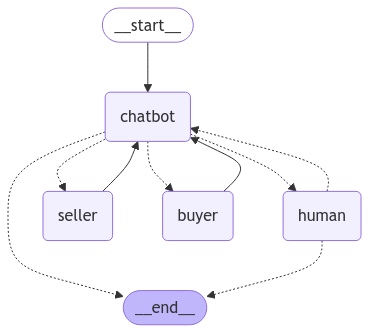

In [31]:


graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("seller", seller_node)
graph_builder.add_node("buyer", buyer_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", seller_or_buyer2)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("seller", "chatbot")
graph_builder.add_edge("buyer", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Display(graph_with_order_tools.get_graph().draw_mermaid_png())



In [32]:
# The default recursion limit for traversing nodes is 25 - setting it higher
# means you can try a more complex order with multiple steps and round-trips.
config = {"recursion_limit": 100}

# Uncomment this line to execute the graph:
state = graph_with_order_tools.invoke({"messages": []}, config)

in chatbot
in seller_or_buyer2
to human node
in human_node
Model: Welcome to Lior's Motorcycle Store. Type `q` to quit. How may I help you today?
User: i want a blue jecket
in maybe_exit_human_node
in chatbot
in seller_or_buyer2
to human node
in human_node
Model: I am sorry, I cannot fulfill this request.  I only have information about motorcycles.

User: so can i buy a motorcycle jacket?
in maybe_exit_human_node
in chatbot
in seller_or_buyer2
to human node
in human_node
Model: Please provide more details about the motorcycle jacket you're looking for (e.g., color, style, brand, size).  The more information you give me, the better I can assist you.

User: ?
in maybe_exit_human_node
in chatbot
in seller_or_buyer2
to human node
in human_node
Model: Do you have any further specifications for the motorcycle jacket you'd like to buy?  If not, I can show you our current stock of motorcycle jackets.

User: i want it to be blue
in maybe_exit_human_node
in chatbot
in seller_or_buyer2
to buyer n

In [ ]:

# Initialize the Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
multimodal_llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

# Initialize embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Initialize vector store for product inventory
vector_store = FAISS.from_texts([], embeddings)

# Define the state
class State(BaseModel):
    messages: List[str] = Field(default_factory=list)
    current_operation: str = "idle"
    last_product_added: Dict[str, Any] = Field(default_factory=dict)
    last_search_results: List[Dict[str, Any]] = Field(default_factory=list)

# Define tools
def add_product(image_base64: str, description: str) -> str:
    # Process the image and description
    image_message = HumanMessage(
        content=[
            {"type": "text", "text": f"Describe this motorcycle: {description}"},
            {"type": "image_url", "image_url": f"data:image/jpeg;base64,{image_base64}"}
        ]
    )
    response = multimodal_llm.invoke([image_message])
    
    # Extract relevant information and add to vector store
    product_info = response.content
    vector_store.add_texts([product_info], metadatas=[{"description": description}])
    
    return f"Product added successfully: {product_info}"

def search_product(query: str) -> pd.DataFrame:
    """Get item request description from the buyer and return the two most fitting products from the stock database.
    
    Returns:
        a pandas DataFrame of the two most fitting products.
    """
    test_query_embedding = query_embeddings.embed_query(query)
    scores = stock_df["text_embedding"].apply(lambda x: np.array(test_query_embedding) @ np.array(x[0]))
    return stock_df.loc[scores.sort_values(ascending=False).index[:2],["description","image_path"]]

# Create tool executor
tools = [
    Tool(name="add_product", func=add_product, description="Add a new product to the inventory"),
    Tool(name="search_product", func=search_product, description="Search for products in the inventory")
]
tool_executor = ToolExecutor(tools)

# Define graph nodes
def process_message(state: State) -> Dict[str, Any]:
    last_message = state.messages[-1]
    
    if "image" in last_message.lower() and "add" in last_message.lower():
        state.current_operation = "add_product"
        return {"next_node": "add_product_node"}
    elif "search" in last_message.lower() or "find" in last_message.lower():
        state.current_operation = "search_product"
        return {"next_node": "search_product_node"}
    else:
        return {"next_node": "generate_response"}

def add_product_node(state: State) -> Dict[str, Any]:
    # In a real scenario, you'd extract the base64 image and description from the message
    # For this example, we'll use placeholder values
    image_base64 = "base64_encoded_image_data"
    description = "New sport motorcycle, red color, 1000cc engine"
    
    result = tool_executor.execute(
        ToolInvocation(
            tool="add_product",
            tool_input={"image_base64": image_base64, "description": description}
        )
    )
    
    state.last_product_added = {"result": result}
    return {"next_node": "generate_response"}

def search_product_node(state: State) -> Dict[str, Any]:
    query = state.messages[-1]
    
    result = tool_executor.execute(
        ToolInvocation(
            tool="search_product",
            tool_input={"query": query}
        )
    )
    
    state.last_search_results = result
    return {"next_node": "generate_response"}

def generate_response(state: State) -> Dict[str, Any]:
    if state.current_operation == "add_product":
        response = f"Product added: {state.last_product_added['result']}"
    elif state.current_operation == "search_product":
        response = "Here are the search results:\n" + "\n".join([f"- {product['product_info']}" for product in state.last_search_results])
    else:
        response = "I'm here to help you add products or search for motorcycles. What would you like to do?"
    
    state.messages.append(response)
    return {"next_node": "end"}

# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("process_message", process_message)
workflow.add_node("add_product_node", add_product_node)
workflow.add_node("search_product_node", search_product_node)
workflow.add_node("generate_response", generate_response)

# Add edges
workflow.set_entry_point("process_message")
workflow.add_edge("process_message", "add_product_node")
workflow.add_edge("process_message", "search_product_node")
workflow.add_edge("process_message", "generate_response")
workflow.add_edge("add_product_node", "generate_response")
workflow.add_edge("search_product_node", "generate_response")
workflow.add_edge("generate_response", "end")

# Compile the graph
app = workflow.compile()

# Function to run the bot
def run_motorcycle_store_bot(user_input: str) -> str:
    state = State(messages=[user_input])
    result = app.invoke(state)
    return result.messages[-1]

# Example usage
print(run_motorcycle_store_bot("Add a new red sport motorcycle to the inventory"))
print(run_motorcycle_store_bot("Search for sport motorcycles"))